<a href="https://colab.research.google.com/github/kristianJW54/ML-AI-Models-Projects/blob/main/Tree_Models/Decision_Tree_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision Tree - Theory and how to build#

**Key Topics**

- What is a random forest
- Gini Impurity
- Nodes and Leafs
- Key parameters
- Weighted Information Gain
- Classes Involved
- Grid Search and Hyperparameter Tuning

Decision Trees are comprised of a set of connected nodes where binary decisions are made to define how the data are split. Data can be pictured as ‘flowing’ through the tree, passing from node to node, until a final partition of the data is arrived at.

The node from which data flows from can be termed the parent, while the node to which data flows to is the child. There are 3 types of nodes:

- Root node: this is where all the data starts and where the initial decision rule is applied. This node has no parent.

- Interior nodes: these are the locations where decision rules are applied on the data that are passed from the parent. The resulting partitioned data are then passed to the children.

- Leaf nodes: these nodes define the final partition of the data, and determine the ultimate output of the model.  These nodes have no children.

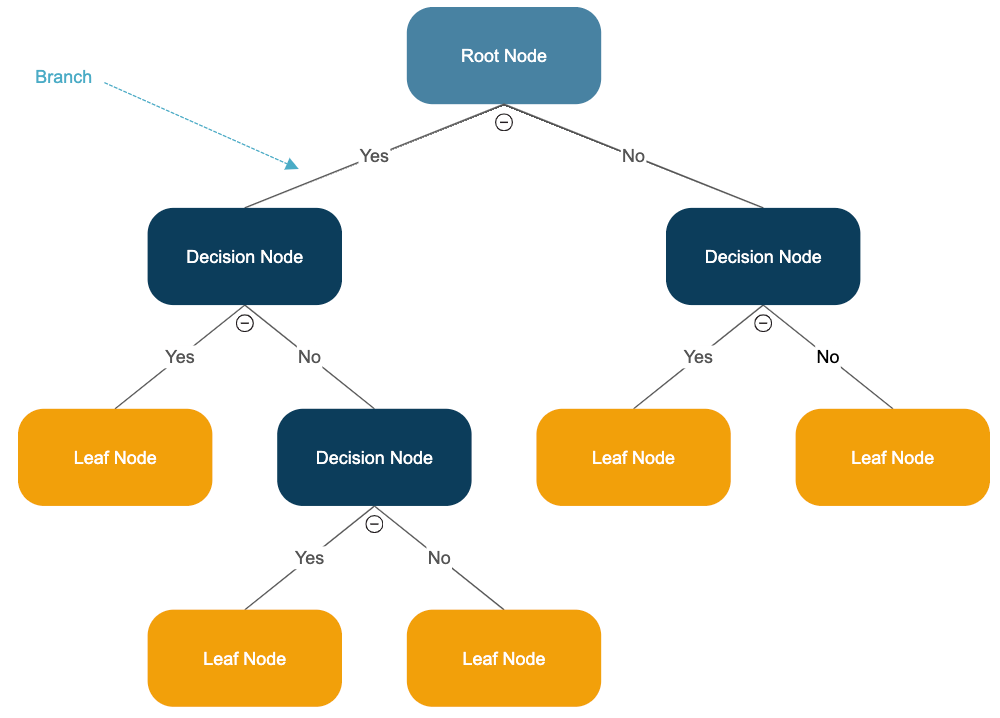

**A decision tree will take a feature at the root node and split the data.**

For example, for a dataset of computer metrics we might have GPU Temp, CPU Usage etc. If we were to try and predict whether or not the computer was running
a video game, a decision tree will split the feature on GPU Temp of > 65 degrees as playing a game and then < 65 as not playing a game.

But in the case that certain applications may also cause a rise in GPU Temp of > 65, the subsequent branch would also contain instances of data which is 'playing a game' and 'not playing a game' in the same node. As well, in the other branch node, some games may also run at a lower temp which will also cause some impurity for that node.

A further decision is made to split the data to reduce the impurity based on the information gain.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

#Creating a test datset with demonstrative features (decisions)
np.random.seed(42)

#First creating number of samples to be included in data
num_samples = 50

#Creating the running game data ranges
cpu_running_game = np.random.uniform(20,100,num_samples)
gpu_running_game = np.random.uniform(70,90,num_samples)
ram_running_game = np.random.uniform(16,32,num_samples)
is_running = np.ones(num_samples)

#Creating the non-running data ranges ensuring some overlap
cpu_non_running = np.random.uniform(20,80, num_samples)
gpu_non_running = np.random.uniform(30,70, num_samples)
ram_non_running = np.random.uniform(8,16, num_samples)
not_running = np.zeros(num_samples)

#Combining
cpu_usage = np.concatenate([cpu_running_game, cpu_non_running])
gpu_temp = np.concatenate([gpu_running_game, gpu_non_running])
ram_usage = np.concatenate([ram_running_game, ram_non_running])
task = np.concatenate([is_running, not_running])

df = pd.DataFrame({
    "CPU Usage" : cpu_usage,
    "GPU Temp" : gpu_temp,
    "RAM Usage" : ram_usage,
    "Is Running Game" : task
})

#Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head(10)


,CPU Usage,GPU Temp,RAM Usage,Is Running Game
0,72.640361,49.700708,8.751856,0.0
1,49.367166,65.942168,10.535376,0.0
2,60.653862,56.304516,14.474889,0.0
3,73.001783,79.875912,16.590191,1.0
4,40.702399,85.419344,20.557448,1.0
5,55.212199,79.444299,31.548513,1.0
6,43.371572,70.110442,21.088056,1.0
7,40.463981,61.792452,15.120043,0.0
8,21.646760,77.773546,20.636023,1.0
9,49.963210,89.391693,16.502867,1.0


### Impurity and Cost Functions of Decision Trees

As with most machine learning, the model uses a cost function. The cost function measures the impurity at each split of the data.

For example, if we split the data by GPU > 75 we can check the impurity by measuring how many rows have been misclassified by the 'model' making a feature split at that point.

In short, the cost function of a decision tree seeks to find those cuts that minimize impurity.

In [ ]:

def data_split_test(split, text):
  return df.loc[(df[text] >= split) & (df["Is Running Game"] == 0),:].shape[0]

column = "GPU Temp"

print(f"Misclassified at GPU Temp > 60: {data_split_test(60, column)}")
print(f"Misclassified at GPU Temp > 50: {data_split_test(50, column)}")



Misclassified at GPU Temp > 60: 12
Misclassified at GPU Temp > 50: 28


Using the above splits, a decision tree would choose to split the data for GPU Temp > 60 as this is what minimzes the impurity.

### Calculate Entropy

The entropy is calculated using the target variable (in this example the "Is Running Game" labels)

At the root node, the impurity is calculated for the whole dataset

In [ ]:
#Calculating Impurity for the data

#Selecting the class labels
y = df[["Is Running Game"]]

def impurity(data):

  unique_classes, class_counts = np.unique(data, return_counts=True)
  p = class_counts / len(data)
  entropy = -np.sum(p * np.log2(p + 1e-10))  # Adding a small value to avoid log(0)

  return entropy

print(impurity(y))

0.9999999997114609


Once the data is split, the impurity is calculated for each subset of data after the split

In [ ]:
#Splitting the data to view how impurity changes

#Split on GPU Temp > 50

df_split_1 = df[df["GPU Temp"] >= 50]
df_split_2 = df[df["GPU Temp"] < 50]

print("Entropy for GPU Temp > 50")
print(impurity(df_split_1["Is Running Game"]))
print(" ")
print("Entropy for GPU Temp < 50")
print(impurity(df_split_2["Is Running Game"]))


Entropy for GPU Temp > 50
0.9418285351589766
 
Entropy for GPU Temp < 50
-1.4426951601859516e-10


Here the first split is less pure and the second is almost close to zero which is very pure

When considering what features to split, the information gain is calculated which enables the decision tree to split on the best features and values

### Information Gain

As we have seen, cuts are compared by impurity. Therefore, we are interested in comparing those cuts that generate less impurity. For this, Information Gain is used. This metric indicates the improvement when making different partitions and is usually used with entropy

To calculate information gain, you need to compare the impurity of the parent node (before the split) with the weighted average impurity of the child nodes (after the split). The formula for information gain is as follows:

**Information Gain (D, Feature) = Impurity(D) - ∑ⱽ|D/Dᵥ| * Impurity(Dᵥ)**

- Where D is the data before the split
- V is the number of subsets created after the split
- Dᵥ is the subset corresponding to the vth child node
- |D| and |dᵥ| are the sizes of the subsets and the original dataset, respectively
- Impurity() represents the impurity measure (entropy or Gini impurity)


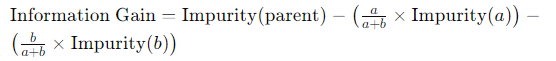

In [ ]:
#Example of information gain function

def info_gain(parent_set, subsets):

  #First part of the formula - to calculate the impurity of the parent set
  parent_impurity = impurity(parent_set)

  #Initial variable
  weighted_child_impurity = 0

  #Total instance of parent set
  total_instances = len(parent_set)

  for subset in subsets:
      subset_size = len(subset)

      #|D/Dv| part of the formula
      weight = subset_size / total_instances

      #Last part of the formula: sum|D/Dv| * Impurity(Dv)
      weighted_child_impurity += weight * impurity(subset)

  #Finish the formula by subtracting the parent impurity with the weighted impurity
  gain = parent_impurity - weighted_child_impurity

  return gain

parent = df["Is Running Game"]
subsets = [df_split_1["Is Running Game"], df_split_2["Is Running Game"]]

print("Information Gain")
print(info_gain(parent, subsets))


Information Gain
0.2653737423191984


In [ ]:
#Another example using a mask in the function for Pandas df's

def info(data, mask, func=impurity):
  '''
  It returns the Information Gain of a variable given a loss function.
  data: target variable.
  mask: split choice.
  func: function to be used to calculate Information Gain in case of classification.
  '''

  #A represents the number of instances in the dataset where the mask is TRUE
  a = np.sum(mask)

  #B represent the number of instances in the dataset where the mask is FALSE
  # Check if mask is a scalar (zero-dimensional array)
  if mask.ndim == 0:
      b = 0  # No instances where the mask is FALSE
  else:
      # B represents the number of instances in the dataset where the mask is FALSE
      b = mask.shape[0] - a

  # Func(data) represents the impurity of the parent data
  # Func(data[mask]) represents the subset where the mask = TRUE
  # Func(data[-mask]) represents the subset where the mask = FALSE

  # a/(a+b) and b/(a+b) are the proportions of instances in each subset relative to the total number of instances in the original
  # parent data

  # The information gain is then calculated as the difference between the entropy of the entire set
  # before the split and the weighted average entropy of the resulting subsets.


  # Avoid division by zero
  if a == 0 or b == 0:
        return 0

  ig = func(data)-a/(a+b)*func(data[mask])-b/(a+b)*func(data[~mask])

  return ig


mask1 = (df["GPU Temp"] >= 50).values
# print(mask1)
print(mask1.shape[0])

print("Information Gain")
print(info(df["Is Running Game"], mask1))

100
Information Gain
0.2653737423191984




---



#### Next Steps

**Having calculated the information gain on splitting data, the next steps would be to:**

1. Calculate the Information Gain for all variables.
2. Choose the split that generates the highest Information Gain as a split.
3. Repeat the process until at least one of the conditions set by hyperparameters of the algorithm is not fulfilled.

For example:

For GPU Temp, we would loop through every unique value and calculate the impurity of if we was to split the data at that value as well as the information gain.
From there we would then determine the best value to split on and using recursion, repeat the process

**Choosing the best split**



In [ ]:
# Using arrays as input, define a function which loops through each column and row and calculates the best split and feature
X = df[["CPU Usage", "GPU Temp", "RAM Usage"]].values
y = df["Is Running Game"].values


def find_best_split(X, y):

  best_feature = None
  best_split = None

  # Initialising with less than 0 for splits which produce pure results
  best_gain = -1


  # Loop through the range of columns
  for feature in range(X.shape[1]):
    # Getting unique values for all rows in that feature
    unique_values = np.unique(X[:, feature])[1:]

    # Looping through each value in unique array
    for split in unique_values:
      # Creating a binary mask for the threshold

      mask = X[:, feature] < split
      mask = np.ravel(mask)

      # Using the previous defined information gain function (with the impurity funcion within that) we will calculate the info gain for the split
      # IMPORTANT! Must use the mask as the parameter in the info gain function and NOT the split value
      info_gain = info(y, mask)

      if info_gain > best_gain:
        best_gain = info_gain
        best_feature = feature
        best_split = split

  return best_feature, best_split, best_gain

best_feature, best_split, best_gain = find_best_split(X, y)

# Creating split_df DataFrame
split_df = pd.DataFrame({
    "Feature": [df.columns[best_feature]],
    "Best Split": [best_split],
    "Best Gain": [best_gain]
})


split_df

,Feature,Best Split,Best Gain
0,GPU Temp,70.110442,1.0


**Above Function Explained**

1) To start we have to prepare for how we want our data to be fed into the function, as a series or an array
2) We then decide how we want to track our changes, if we want to store our values within the loops in a list, or intialise variables to later store our best results
3) We then begin our first Loop:
  - The first loop will take the range of the shape of the features array (the number of columns) this will allow us to capture the range of the loop for when we begin our second loop through each row and value
  - We then capture the unique values of each column, looping through until we have a list of unique values for each
  - To help with capturing the best information and split, we can ignore the first data point as splitting on that will result in all values being above and none below
4) From here we begin the second loop to look at each value of each column.
  - This is where each split will be evaluated to see if splitting on that value will result in the best information gain/best split
  - For this we apply a mask or a simple logical comparison, which will apply a boolean value to the unique array as to whether the values are above or below the current value we are looking to split on
  - From here we then apply the info gain function to measure how much impurity and information gain we can expect if we were to split on this value
  - The process is repeated for each value in each column
5) We can append the splits, indexes and values to lists for tracking
6) Outside of the loops, we can write a logical statement to capture the best feature, the best split and the best gain

### Training A Tree

- Max Depth
- Min Samples Split
- Min Information Gain

In order to train and build a tree, we'll have to define node objects by either using classes or functions that we can call and create to store the features, splits and predictions.
First we must define a split function to split the data into left or right subsets. We will be using the best_split function which will output our best feature and value to split and use this as input to a split function.
The left and right subsets will be stored as nodes/leaves and after checking parameters we can then recursively call the split function which will build the tree further.

One important thing to note is that the depth of the tree should be defined either explicitly or by reaching a maximum purity leaf node

Other parameters to consider will be the min samples split and the min information gain. Both of these will help tune the tree to improve accuracy and predicionts (explained in more detail further on)

In [ ]:
from scipy.stats import mode

class Node:
  def __init__(self, feature_index=None, split=None, left=None, right=None, value=None):
    # The index of the feature to split on
    self.feature_index = feature_index
    # Threshold for the split
    self.split = split
    self.left = left
    self.right = right
    # Value if the node is a leaf node
    self.value = value


def build_tree(X , y, depth=0, max_depth=None, min_samples_leaf=1):
    """
    Recursively builds a decision tree based on the provided feature matrix X and target variable y.

    Parameters:
    - X: Feature matrix (numpy array) containing the input features for each data point.
    - y: Target variable (numpy array) containing the class labels for each data point.
    - depth: Current depth of the tree (used for stopping criteria).
    - max_depth: Maximum depth allowed for the tree (stopping criteria).
    - min_samples_leaf: Minimum number of samples required to create a leaf node (stopping criteria).

    Returns:
    - Node object representing the root of the decision tree.
    """

    # Stopping criteria: If the maximum depth or minimum samples leaf condition is met, create a leaf node.
    if depth == max_depth or len(X) <= min_samples_leaf:
        unique_values, counts = np.unique(y, return_counts=True)
        mode_index = np.argmax(counts)
        majority_class = unique_values[mode_index]
        return Node(value=majority_class)

    # Find the best split feature and threshold, as well as the information gain.
    best_feature, best_split, best_gain = find_best_split(X, y)

    # If the information gain is zero, create a leaf node with the majority class.
    if best_gain == 0:
        unique_values, counts = np.unique(y, return_counts=True)
        mode_index = np.argmax(counts)
        majority_class = unique_values[mode_index]
        return Node(value=majority_class)

    # Create a binary mask based on the best split feature and threshold.
    mask = X[:, best_feature] < best_split

    # Recursively build the left and right branches of the tree.
    left_branch = build_tree(X[mask], y[mask], depth + 1, max_depth, min_samples_leaf)
    right_branch = build_tree(X[~mask], y[~mask], depth + 1, max_depth, min_samples_leaf)

    # Create and return the current node with information about the split.
    return Node(feature_index=best_feature, split=best_split, left=left_branch, right=right_branch)



def print_tree(node, depth=0):
    indent = "  " * depth
    if node.value is not None:
        print(f"{indent}Leaf Node: Predicted Class {node.value}")
    else:
        print(f"{indent}Split on Feature {node.feature_index} at {node.split}")
        print_tree(node.left, depth + 1)
        print_tree(node.right, depth + 1)

# Assuming df is your DataFrame and y is your target variable
X = df.drop("Is Running Game", axis=1).values
y = df["Is Running Game"].values



tree = build_tree(X, y, max_depth=3, min_samples_leaf=5)
print_tree(tree)




Split on Feature 1 at 70.11044234247206
  Split on Feature 0 at 34.37371344001835
    Leaf Node: Predicted Class 0.0
    Split on Feature 0 at 35.47649766290934
      Leaf Node: Predicted Class 0.0
      Leaf Node: Predicted Class 0.0
  Split on Feature 0 at 34.54599737656805
    Leaf Node: Predicted Class 1.0
    Split on Feature 0 at 35.97390257266878
      Leaf Node: Predicted Class 1.0
      Leaf Node: Predicted Class 1.0


**Interpretation**

From the output above, we see that the first split is taken on Feature 1 where the threshold is 70
The first branch and node is then split on Feature 0 at threshold 34
A leaf node is created which predicts class 0

So for GPU Temps below 70 and for CPU Usage below 35 it is predicted that a game is NOT running.
If GPU Temp is above 70 and CPU Usage is above 34 it is predicted that game IS running